In [30]:
from scipy import *
from scipy.linalg import norm, pinv, svd
from matplotlib import pyplot as plt
from numpy.linalg import det
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error 

LAMBDA=0.0

def gendist(X,Y):
  return cdist(X,Y,metric='euclidean')

class RBF:
     
    def __init__(self, centers, outdim, R):
        indim = centers.shape[1]
        numCenters = centers.shape[0]
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = centers
        self.R = R
        self.W = np.random.random((self.numCenters, self.outdim))
        self.TRAINING_X_DATA = []
        
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return np.exp(-1/(self.R)**2 * norm(c-d)**2)
    
    def _basisfuncFast(self, c, d, dist_mat):
        print("_basisfuncFast ---> STARTED")
        ret = np.exp(-1/(self.R)**2 * dist_mat**2)
        print("_basisfuncFast ---> ENDED")
        return ret
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        
        if G.shape[0] == G.shape[1]:
           print('det(G) = ', det(G))
        
        return G
    
    def _calcActFast(self, X):
        G = np.zeros((X.shape[0], self.numCenters), float)

        self.centers = np.vstack(self.centers[:,:]).astype(np.float64)
        X = np.vstack(X[:,:]).astype(np.float64)

        dist_mat = gendist(self.centers, X)
        print("distance matrix ...  beeing calculated - STARTED")
        G = self._basisfuncFast(self.centers, X, dist_mat)
        print("distance matrix ...  beeing calculated - ENDEDED")

        print('X.shape[0]=',X.shape[0], 'self.numCenters=',self.numCenters)
       
        if G.shape[0] == G.shape[1]:
           print('det(G) = ', det(G))
        
        return G

    def wypiszZbior(self, X, tekst):
        print(tekst)
        for i in range(X.shape[0]):
            print(i,X[i,:])
        
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        self.TRAINING_X_DATA = X
        
        # self.wypiszZbior(X,'ZBIOR TRENINGOWY ----------------------->')
        G = self._calcAct(X)
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
        
    def trainRegularized(self, X, Y, _lambda=0):
        print("Regularized RBF training.")
        self.wypiszZbior(X,'ZBIOR TRENINGOWY ----------------------->')
        
        self.TRAINING_X_DATA = X
        
        G = self._calcActFast(X)
        U, S, VT = svd(G)
        self.wartosci_szczegolne = S
        
        S_inv = S*S-_lambda
        
        print('VT.shape=',VT.shape)
        print('S.shape=',S.shape)
        print('U.shape=',U.shape)
        
        N = G.shape[0]
        
        r = N
        for i in range(N):
            if S[i] < _lambda:
                r = i
                break
                
        W_final = np.zeros((G.shape[0], Y.shape[1]))
    
        for ii in range(Y.shape[1]):
            w_lambda = np.zeros(G.shape[0])
            for i in range(r):
                sigma = S[i]
                uTi = U[:,i].transpose()
                y = Y[:,ii]
                vi = VT.transpose()[:,i]
                f = sigma**2/(sigma**2+_lambda**2)
                w_lambda += 1/sigma*f*np.dot(np.dot(uTi,y),vi)
            W_final[:,ii] = w_lambda

        print('r=',r)
        
        self.W = W_final
        
    def test(self, X, treningowy = False):
        """ X: matrix of dimensions n x indim """
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y


In [31]:
import numpy as np

def standardize_dataset(data):
    """
    Standaryzuje dane: (wartość - średnia) / odchylenie standardowe.

    :param data: dane do standaryzacji
    :return: standaryzowane dane
    """
    mean_value = np.mean(data)
    std_dev = np.std(data)
    standardized_data = [(value - mean_value) / std_dev for value in data]
    
    return np.array(standardized_data)


In [32]:
import numpy as np

def prepare_data(data, target_index, sequence_length):
    """
    Przygotowuje dane do modelu sekwencyjnego.

    :param data: dane wejściowe
    :param target_index: indeks kolumny docelowej
    :param sequence_length: długość sekwencji wejściowych
    :return: przekształcone dane wejściowe i docelowe
    """
    input_data = []
    target_data = []
    
    for i in range(len(data) - sequence_length - 1):
        sequence_data = data[i:(i + sequence_length)]
        reshaped_sequence = sequence_data.values.reshape(sequence_data.shape[0] * sequence_data.shape[1])

        target_sequence = data[(i + sequence_length):(i + sequence_length + 1)][target_index]
        
        input_data.append(reshaped_sequence)
        target_data.append(target_sequence)
    
    return np.array(input_data), np.array(target_data)


In [33]:
import numpy as np

def compute_max_distance(data):
    """
    Oblicza najdłuższy dystans między dowolnymi dwoma punktami w zestawie danych.

    :param data: zestaw danych
    :return: najdłuższy obliczony dystans
    """
    max_distance = 0
    
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            current_distance = np.linalg.norm(data[i] - data[j])
            max_distance = max(max_distance, current_distance)
    
    return max_distance


In [34]:
import numpy as np
import math

def apply_kohonen_algorithm(data, num_iterations, initial_learning_rate, num_representatives, learning_rate_decay, measure, decay_rate1, decay_rate2, standardize):
    """
    Implementacja algorytmu Kohonena do uczenia sieci neuronowych bez nauczyciela.

    :param data: dane wejściowe
    :param num_iterations: liczba iteracji do wykonania
    :param initial_learning_rate: początkowa wartość współczynnika uczenia
    :param num_representatives: liczba reprezentantów
    :param learning_rate_decay: typ zmniejszania współczynnika uczenia (1: liniowe, 2: wykładnicze, 3: hiperboliczne)
    :param measure: typ miary (1, 2, 3)
    :param decay_rate1: parametr C1 dla wykładniczego i hiperbolicznego zmniejszania współczynnika uczenia
    :param decay_rate2: parametr C2 dla hiperbolicznego zmniejszania współczynnika uczenia
    :param standardize: czy dane mają być standaryzowane
    :return: wektory reprezentantów, tablica m, dane wejściowe
    """

    # Standaryzacja danych
    if standardize:
        data = standardize_dataset(data)

    # Inicjalizacja i normalizacja wektorów reprezentantów
    representative_vectors = initialize_representative_vectors(len(data), num_representatives, len(data[0]))

    # Wybór miary i wykonanie iteracji
    measure_table = [0]*len(data)
    learning_rate = initial_learning_rate

    for iteration in range(num_iterations):
        chosen_representative = apply_measure(measure, data, iteration, num_representatives, representative_vectors)
        measure_table[iteration%len(data)] = chosen_representative

        # Modyfikacja wektorów reprezentantów
        representative_vectors[chosen_representative] += learning_rate * (data[iteration%len(data)] - representative_vectors[chosen_representative])
        representative_vectors[chosen_representative] /= np.linalg.norm(representative_vectors[chosen_representative])

        # Aktualizacja współczynnika uczenia
        learning_rate = update_learning_rate(learning_rate_decay, initial_learning_rate, num_iterations, iteration, decay_rate1, decay_rate2)

    return representative_vectors, measure_table, data


def initialize_representative_vectors(data_length, num_representatives, data_width):
    vectors = []
    random_generator = np.random.RandomState(0)

    for _ in range(num_representatives):
        for _ in range(data_length):
            temp_vector = random_generator.normal(loc=0.0, scale=0.01, size=data_width)
            vectors.append(temp_vector/np.linalg.norm(temp_vector))

    return np.array(vectors)


def apply_measure(measure, data, iteration, num_representatives, representative_vectors):
    if measure == 1:
        return dot_product_measure(data, iteration, num_representatives, representative_vectors)

    if measure == 2:
        return euclidean_distance_measure(data, iteration, num_representatives, representative_vectors)

    if measure == 3:
        return manhattan_distance_measure(data, iteration, num_representatives, representative_vectors)


def update_learning_rate(learning_rate_decay, initial_learning_rate, num_iterations, current_iteration, decay_rate1, decay_rate2):
    if learning_rate_decay == 1:  # Liniowe zmniejszanie
        return initial_learning_rate * (num_iterations - current_iteration) / num_iterations

    if learning_rate_decay == 2:  # Wykładnicze zmniejszanie
        return initial_learning_rate * math.exp(-decay_rate1 * current_iteration)

    if learning_rate_decay == 3:  # Hiperboliczne zmniejszanie
        return decay_rate1 / (decay_rate2 + current_iteration)


In [35]:
import numpy as np
import math

def dot_product_measure(data, iteration_index, num_representatives, representative_vectors):
    """
    Miara podobieństwa oparta na iloczynie skalarnym (miara 3).

    :param data: dane wejściowe
    :param iteration_index: indeks iteracji
    :param num_representatives: liczba reprezentantów
    :param representative_vectors: wektory reprezentantów
    :return: indeks reprezentanta o największej miarze
    """
    measurements = [np.dot(representative_vectors[i], data[iteration_index % len(data)]) for i in range(num_representatives)]
    
    max_index = np.argmax(measurements)
    return max_index


def euclidean_distance_measure(data, iteration_index, num_representatives, representative_vectors):
    """
    Miara podobieństwa oparta na odległości euklidesowej (miara 4).

    :param data: dane wejściowe
    :param iteration_index: indeks iteracji
    :param num_representatives: liczba reprezentantów
    :param representative_vectors: wektory reprezentantów
    :return: indeks reprezentanta o najmniejszej miarze
    """
    measurements = [np.linalg.norm(representative_vectors[i] - data[iteration_index % len(data)]) for i in range(num_representatives)]
    
    min_index = np.argmin(measurements)
    return min_index


def manhattan_distance_measure(data, iteration_index, num_representatives, representative_vectors):
    """
    Miara podobieństwa oparta na odległości Manhattan (miara 5).

    :param data: dane wejściowe
    :param iteration_index: indeks iteracji
    :param num_representatives: liczba reprezentantów
    :param representative_vectors: wektory reprezentantów
    :return: indeks reprezentanta o najmniejszej miarze
    """
    measurements = [sum(abs(representative_vectors[i][j] - data[iteration_index % len(data)][j]) for j in range(len(representative_vectors[0]))) for i in range(num_representatives)]
    
    min_index = np.argmin(measurements)
    return min_index


In [40]:
def plot_results(expected, predicted_kmeans, predicted_kohonen, num_clusters, limit):
    plt.grid()
    plt.plot(expected, '-', label='Oczekiwane wartości', c='red')
    plt.plot(predicted_kmeans, '-', label='Przewidywane wartości Kmeans',c= 'blue')
    plt.plot(predicted_kohonen, '-', label='Przewidywane wartości Kohonen',c= 'green')
    
    plt.title(f"Liczba Centrów Danych: {num_clusters}\n Limit Predykcji: {limit}", size=10)
    plt.legend()
    
    # Zapisanie wykresu z ustandaryzowaną nazwą
    filename = f"plot_cluster_{num_clusters}_limit_{limit}_.png"
    # plt.savefig(filename)
    plt.show()


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans

# wczytanie danych
data = pd.read_csv('all_stocks_5yr.csv')
df = data[data['Name'] == 'MSFT']
X_df = df[['open', 'high', 'low', 'close']].head(1000)

# parametry
alpha = 0.1 
iter = 5000 
measure = 1 
learning_rate = 1 
C1 = 0.5
C2 = 0.5
standardize_data = True 

cluster_values = [5]#,10,25,50,100]
limit_values = [1]#,5,10,15,20]

import warnings
warnings.filterwarnings("ignore")


Mean Absolute Error Value for Kohonen is :  0.857
Mean Absolute Error Value for Kmeans is :  0.6126


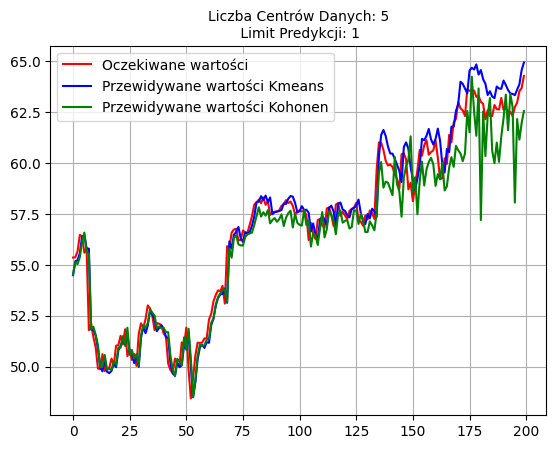

In [ ]:
# Otwórz plik tekstowy do zapisu
with open("results1.txt", "w") as file:
    for num_clusters in cluster_values:
        for limit in limit_values:
            # Preparacja danych
            data,expected_vals = prepare_data(X_df, 'close', limit)
            standardized_data = standardize_dataset(data) 
            X_train, X_test, y_train, y_test = train_test_split(standardized_data, expected_vals, test_size=0.2, shuffle=False)

            # Kohonen
            centers, predicts, X = apply_kohonen_algorithm(X_train, iter, alpha, num_clusters, learning_rate, measure, C1, C2, standardize_data)
            max_distance = compute_max_distance(standardized_data)
            rbf = RBF(centers, num_clusters, max_distance)
            rbf.train(X_train, y_train)
            output_kohonen = rbf.test(X_test)
            MAEValue_kohonen = round(mean_absolute_error(y_test, output_kohonen),4) 
            print('Mean Absolute Error Value for Kohonen is : ', MAEValue_kohonen)

            # KMeans
            kmeans = KMeans(n_clusters=num_clusters, random_state=0)
            kmeans.fit(X_train)
            centers = kmeans.cluster_centers_
            centers = np.array(centers)
            max_distance = compute_max_distance(standardized_data)
            rbf = RBF(centers, num_clusters, max_distance)
            rbf.train(X_train, y_train)
            output_kmeans = rbf.test(X_test)
            MAEValue_kmeans = round(mean_absolute_error(y_test, output_kmeans),4) 
            print('Mean Absolute Error Value for Kmeans is : ', MAEValue_kmeans)

            # Rysowanie wykresu
            plot_results(y_test, output_kmeans, output_kohonen, num_clusters, limit)

            # Zapisz wyniki MAE do pliku tekstowego
            #file.write(f"Cluster: {num_clusters}, Limit: {limit}, MAE for Kohonen: {MAEValue_kohonen}, MAE for Kmeans: {MAEValue_kmeans}\n")

